# Predicting defaulting on credit card applications

When customers come in financial difficulties, it usually does not happen completely out of the blue. There are indicators which can be used to anticipate the final outcome, such as late payments, calls to the customer services, enquiries about the products, a different browsing pattern on the web or mobile app. By using such patterns it is possible to prevent, or at least guide the process and provide a better service for the customer as well as reduced risks for the bank.

In this project an attempt is made to predict defaulting, using statistics, machine learning and deep learning. This is done through making use of a dataset that contains data about payments, delayed payments, amounts to be payed and information wether the person defaulted within the next 6 months or not. The main focus of this project is to see how XAI algorithms, in particular SHAP values can be used to generate explanations for why a default could occur 6 months down the line. This project forms the basis upon which a knowledge base could be build that could generate automated explanations and automated warnings. An automated warning might be interesting to prevent a default from occurring a few months down the road. SHAP offers the unique property that you can look at a case by case basis which factors influenced an algorithm to give a classification (e.g. default or not default).

### Synopysis

This notebook unfolds in the following phases

  - Downloading the data
  - Data clean up 
  - Descriptive analytics
  - Feature selection, feature scaling, feature engineering
  - Modeling the algorithm with Gradient Boosting Decision Trees
  - Explainability through SHAP values 

### Source

The dataset is availble at the Center for Machine Learning and Intelligent Systems, Bren School of Information and Computer Science, University of California, Irvine: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Citation:  
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

The dataset Name: I-Cheng Yeh 
email addresses: (1) icyeh '@' chu.edu.tw (2) 140910 '@' mail.tku.edu.tw  
institutions: (1) Department of Information Management, Chung Hua University, Taiwan. (2) Department of Civil Engineering, Tamkang University, Taiwan. other contact information: 886-2-26215656 ext. 3181 

Extract from the [dataset information section][1] :
"This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients."

[1]:[https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients]

#### Imports

In [1]:
#data import
import wget
import urllib

# regex
import re

#time
import pytz as tz
from datetime import datetime

#data explore
import numpy as np
np.random.seed(1337)

#support for reading excel files
import xlrd

# dataframes in python
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

#### Data preparation
We cache the data set from the above mentioned repository in a local directory. 

In [3]:
import os
import shutil

datadir = 'C:/Users/Michael/Documents/deepcredit-master/data'
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [4]:
# Get the dataset from UCI

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls' 
filename = os.path.join(datadir, 'default of credit card clients.xls')

if not os.path.isfile(filename):
    wget.download(url, out=filename)

#### Convert the data
We use pandas to read the data from its original excel format into a dataframe

In [5]:
df = pd.read_excel(filename, header=1)

#### Clean up
We lowercase the column name, and rename the column names when required,
In particular, remarkably this dataset misses a colum `PAY_1`. In the analysis here below we assume that PAY_0 is actually pay_1, to be consider the repayment of the month prior to the month where we calculate the defaulting (which is October 2005, in this particular dataset)

In [6]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

In [7]:
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))


Explanatory variables:  23
Number of Observations: 30000
Target variable:       'default payment next month' -> 'target'


#### Attributes description
This study uses 23 variables as explanatory variables, extracted/interpreted from : 
    
```
   ----------------------------------------------------------------------------------------
   Name                 Explantion        
   -------------------- -------------------------------------------------------------------
   limit_bal            Amount of the given credit (NT dollar): 
                        it includes both the individual consumer credit 
                        and his/her family (supplementary) credit.
   
   sex                  Gender 
                        (1 = male; 2 = female)
   
   education            Education
                        (1 = graduate school; 2 = university; 3 = high school; 4 = others)
   
   marriage             Marital status 
                        (1 = married; 2 = single; 3 = others)
   
   age                  Age (years)
   
   pay_1 - pay_6        History of past payment. Past monthly payment records 
                        From April to September, 2005 as follows:
                        
                        pay_1 = the repayment status in September, 2005
                        pay_2 = the repayment status in August, 2005
                        ...
                        pay_6 = the repayment status in April, 2005 
                        
                        The measurement scale for the repayment status is: 
                        -1 = pay duly; 
                        1 = payment delay for one month 
                        2 = payment delay for two months
                        ...
                        8 = payment delay for eight months 
                        9 = payment delay for nine months and above
                        
   bill_amt1-bill_amt5  Amount of bill statement (NT dollar). 
                        bill_amt1 = amount of bill statement in September, 2005 
                        bill_amt2 = amount of bill statement in August, 2005
                        ...
                        bill_amt6= amount of bill statement in April, 2005 
                        
   pay_amt1-pay_amt6    Amount of previous payment (NT dollar)
                        pay_amt1 = amount paid in September, 2005
                        pay_amt2 = amount paid in August, 2005
                        ...
                        pay_amt6 = amount paid in April, 2005 
   ----------------------------------------------------------------------------------------
```


#### Descriptive Analytics

##### Payment Delays
An examination is done into payment delays

In [8]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


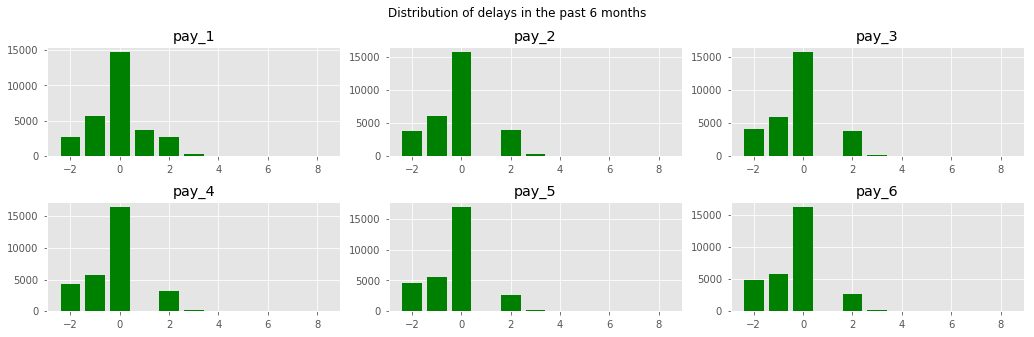

In [9]:
# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of delays in the past 6 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

Some people pay 2 months upfront, others one month upfront, most of them are on par. a few are running behind payments. 

##### Standing credit
It's important to look at how the debts/credit is accumulating over the months, credit to be repaid is a positive number here.

In [10]:
# bill columns
pattern = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in df.columns if (pattern.match(x))]
df[bill_columns].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [11]:
df[bill_columns].head(10)

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,3913,3102,689,0,0,0
1,2682,1725,2682,3272,3455,3261
2,29239,14027,13559,14331,14948,15549
3,46990,48233,49291,28314,28959,29547
4,8617,5670,35835,20940,19146,19131
5,64400,57069,57608,19394,19619,20024
6,367965,412023,445007,542653,483003,473944
7,11876,380,601,221,-159,567
8,11285,14096,12108,12211,11793,3719
9,0,0,0,0,13007,13912


##### Payments in the previous months
Descriptives about how payments are performed in previous months

In [12]:
# pay status columns
pattern = re.compile("^pay_amt[0-9]+$")
pay_amount_columns = [ x for x in df.columns if (pattern.match(x))]
df[pay_amount_columns].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [13]:
df[pay_amount_columns].head(10)

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,0,689,0,0,0,0
1,0,1000,1000,1000,0,2000
2,1518,1500,1000,1000,1000,5000
3,2000,2019,1200,1100,1069,1000
4,2000,36681,10000,9000,689,679
5,2500,1815,657,1000,1000,800
6,55000,40000,38000,20239,13750,13770
7,380,601,0,581,1687,1542
8,3329,0,432,1000,1000,1000
9,0,0,0,13007,1122,0


In [14]:
df['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

#### Explore Defaulting

The first thing to do is examine the data and what the best way is to predict defaulting. 
For this the following questions need to be answered. 

  - What is the balance in defaults vs non defaults in the dataset? 
  - What is the breakdown depending on some of the variables available?


defaulting accounts are 22.12% out of 30000 observations


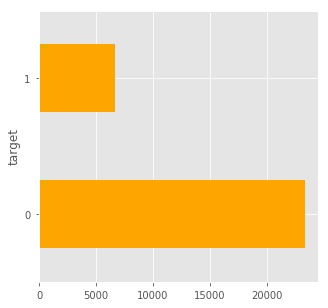

In [16]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')


#### Explore some statistics of defaulting using the categorical variables

The sex, marriage columns get converted into categorical coded variables.

et's make use of categorical features of pandas, by converting target, sex, marriage, education, age and the pay_\* columns to categories

In [17]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])


In [18]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)

In [19]:
#pattern = re.compile("^pay_[0-9]+$")
#pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
#for i in pay_status_columns:
#    df[i] = df[i].astype('category')

### Features

In [20]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

#### From variables to train, test matrices

In [21]:
from sklearn.neighbors.kde import KernelDensity
pattern = re.compile("^bill_relamt[0-9]+$")
columns = [ x for x in df.columns if (pattern.match(x))]

In [22]:
from patsy import dmatrices

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))
formula += '+' + '+'.join(selcols('bill_amt'))
formula += '+' + '+'.join(selcols('pay_amt'))

#### engineered / normalized features

# categorical age and credit limit (binned)
#formula += '+' + 'C(age_cat)'
#formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
#formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
#formula += '+' + 'pay_amt_avg_log'
#formula += '+' + '+'.join(selcols('pay_relamt'))
#formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
#formula += '+' + 'bill_amt_avg_log'
#formula += '+' + '+'.join(selcols('bill_relamt'))
#formula += '+' + '+'.join(selcols('bill_amt_sign'))
#formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]

#### Visualization: Confusion matrices and AUC curves

In [23]:
#Code later used to visualize the accuracy matrix and AUC curve
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])


#### Feature selection

In here features are selected. The dataset was undersampled since earlier it was determined that ~22% of the cases were defaults. This would lead to an imbalance in predictions. Since the dataset is already quite large, undersampling is an acceptable technique here. 

The results of the feature selection show little effect for the categorical variables sex, education and marriage. The payment data seems to indicate best if defaults occur or not. Therefore with a penalty applied, all the descriptive data about a person gets filtered except for age which seem to hold more statistical power. 


In [24]:
brop = X.columns

In [25]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

Using TensorFlow backend.


In [42]:
df = pd.DataFrame(X, columns=brop)
df['y'] = y

In [44]:
df.columns

Index(['Intercept', 'C(sex)[T.F]', 'C(marriage)[T.married]',
       'C(marriage)[T.single]', 'C(marriage)[T.other]', 'C(education)[T.1]',
       'C(education)[T.2]', 'C(education)[T.3]', 'C(education)[T.4]',
       'C(education)[T.5]', 'C(education)[T.6]', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'y'],
      dtype='object')

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Print the name and gini importance of each feature
for feature in zip(brop, clf.feature_importances_):
    print(feature)

('Intercept', 0.0)
('C(sex)[T.F]', 0.012128835116271523)
('C(marriage)[T.married]', 0.008893994543374834)
('C(marriage)[T.single]', 0.009238558500474343)
('C(marriage)[T.other]', 0.0018207497776944939)
('C(education)[T.1]', 0.008940095508739695)
('C(education)[T.2]', 0.009790594234338318)
('C(education)[T.3]', 0.008291102560566211)
('C(education)[T.4]', 0.0005436469994925435)
('C(education)[T.5]', 0.0018862038240325862)
('C(education)[T.6]', 0.0005857658736749099)
('age', 0.07154029328110338)
('pay_1', 0.09194030311511014)
('pay_2', 0.044188718349510145)
('pay_3', 0.03510429984777286)
('pay_4', 0.025914748840906405)
('pay_5', 0.023101550647261816)
('pay_6', 0.015504723122815171)
('bill_amt1', 0.06303112066258841)
('bill_amt2', 0.05705235614177678)
('bill_amt3', 0.05300293954430333)
('bill_amt4', 0.05077795710083473)
('bill_amt5', 0.05171190585458915)
('bill_amt6', 0.05130184809321065)
('pay_amt1', 0.05495825414276003)
('pay_amt2', 0.05266253616865932)
('pay_amt3', 0.05267612825492196)


In [28]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
selector = SelectFromModel(clf, threshold = 0.015)

# Train the selector
selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
       

In [29]:
# Print the names of the most important features
for feature_list_index in selector.get_support(indices=True):
    featlist = []
    featlist.append(brop[feature_list_index])
    print(brop[feature_list_index])

age
pay_1
pay_2
pay_3
pay_4
pay_5
pay_6
bill_amt1
bill_amt2
bill_amt3
bill_amt4
bill_amt5
bill_amt6
pay_amt1
pay_amt2
pay_amt3
pay_amt4
pay_amt5
pay_amt6


In [30]:
top_indices = [brop[x] for x in selector.get_support(indices=True)]

In [31]:
#import warnings
#from sklearn.feature_selection import SelectKBest, f_classif

#warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

#selector = SelectKBest(f_classif, 82)
#selector.fit(X, y)

In [34]:
#top_indices = np.nan_to_num(selector.scores_).argsort()[-18:][::-1]
#selector.scores_[top_indices]
#df.columns[top_indices]
selector

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
       

#### Feature scaling

Minmax scaler was used to scale the variables in an adequate way


In [33]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [34]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

In [109]:
df.iloc[8005]

Intercept                      1.0
C(sex)[T.F]                    1.0
C(marriage)[T.married]         1.0
C(marriage)[T.single]          0.0
C(marriage)[T.other]           0.0
C(education)[T.1]              1.0
C(education)[T.2]              0.0
C(education)[T.3]              0.0
C(education)[T.4]              0.0
C(education)[T.5]              0.0
C(education)[T.6]              0.0
age                           32.0
pay_1                          2.0
pay_2                          2.0
pay_3                          0.0
pay_4                          0.0
pay_5                          2.0
pay_6                          2.0
bill_amt1                 114430.0
bill_amt2                 108202.0
bill_amt3                 108657.0
bill_amt4                 108668.0
bill_amt5                 103867.0
bill_amt6                 111842.0
pay_amt1                       0.0
pay_amt2                    6000.0
pay_amt3                    8200.0
pay_amt4                       0.0
pay_amt5            

In [110]:
y[8005]

1.0

In [111]:
individual_sample_X = X[8005]

In [112]:
presampling = X

In [113]:
y[8000]

1.0

In [115]:
X_prep[8005]

array([0.2037037 , 0.4       , 0.44444444, 0.2       , 0.2       ,
       0.4       , 0.4       , 0.200326  , 0.26339164, 0.25824492,
       0.2741008 , 0.27708067, 0.4970542 , 0.        , 0.00488965,
       0.01613446, 0.        , 0.02381875, 0.00756621])

#### Model selection and validation

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

#### Decision Trees boosting

Running the algorithm and visualizing the results in the accuracy matrix + AUC curve

In [117]:
import xgboost as xgb

In [118]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [119]:
num_round = 12
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[0]	eval-error:0.309981	eval-logloss:0.639642	train-error:0.272111	train-logloss:0.626658
[1]	eval-error:0.307721	eval-logloss:0.611301	train-error:0.265706	train-logloss:0.588354
[2]	eval-error:0.302448	eval-logloss:0.595691	train-error:0.261467	train-logloss:0.564938
[3]	eval-error:0.302448	eval-logloss:0.587637	train-error:0.258548	train-logloss:0.548735
[4]	eval-error:0.297552	eval-logloss:0.583125	train-error:0.256287	train-logloss:0.538669
[5]	eval-error:0.298305	eval-logloss:0.581746	train-error:0.256381	train-logloss:0.529384
[6]	eval-error:0.294539	eval-logloss:0.579716	train-error:0.254497	train-logloss:0.522954
[7]	eval-error:0.296045	eval-logloss:0.580088	train-error:0.253085	train-logloss:0.518247
[8]	eval-error:0.300188	eval-logloss:0.58064	train-error:0.250918	train-logloss:0.512622
[9]	eval-error:0.298682	eval-logloss:0.581991	train-error:0.246868	train-logloss:0.505109
[10]	eval-error:0.299058	eval-logloss:0.582342	train-error:0.245455	train-logloss:0.501717
[11]	eval-

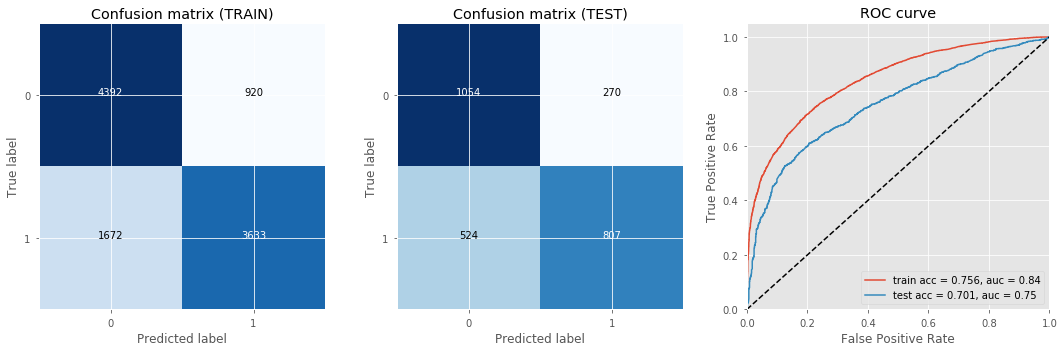

In [120]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### Finding a data point

A data point is chosen inside the index that didn't get filtered out by the algorithm. This datapoint is then further explored later with SHAP values.

In [248]:
np.where(np.all(X_test==X_prep[9022],axis=1))

(array([2025], dtype=int64),)

In [222]:
np.where(np.all(X_train==X_prep[9007],axis=1))

(array([], dtype=int64),)

In [252]:
df.iloc[2025]

Intercept                      1.0
C(sex)[T.F]                    1.0
C(marriage)[T.married]         1.0
C(marriage)[T.single]          0.0
C(marriage)[T.other]           0.0
C(education)[T.1]              0.0
C(education)[T.2]              0.0
C(education)[T.3]              1.0
C(education)[T.4]              0.0
C(education)[T.5]              0.0
C(education)[T.6]              0.0
age                           36.0
pay_1                          0.0
pay_2                          0.0
pay_3                          0.0
pay_4                          0.0
pay_5                          0.0
pay_6                          0.0
bill_amt1                 140479.0
bill_amt2                 133540.0
bill_amt3                 126408.0
bill_amt4                 119174.0
bill_amt5                 111339.0
bill_amt6                 103492.0
pay_amt1                    5000.0
pay_amt2                    5000.0
pay_amt3                    4200.0
pay_amt4                    4000.0
pay_amt5            

### SHAP values

First an individual his factors are visualized. The factors that contribute towards a negative decision and those that contribute towards a positive decision are visualized.  In this case, the pay_amt3 and age play a factor in the decision for the algorithm to label a possible default prospect. 

Later on the individual variables are visualized and the power they have to negatively or positively influence the decision through the data points. 

In [253]:
import shap

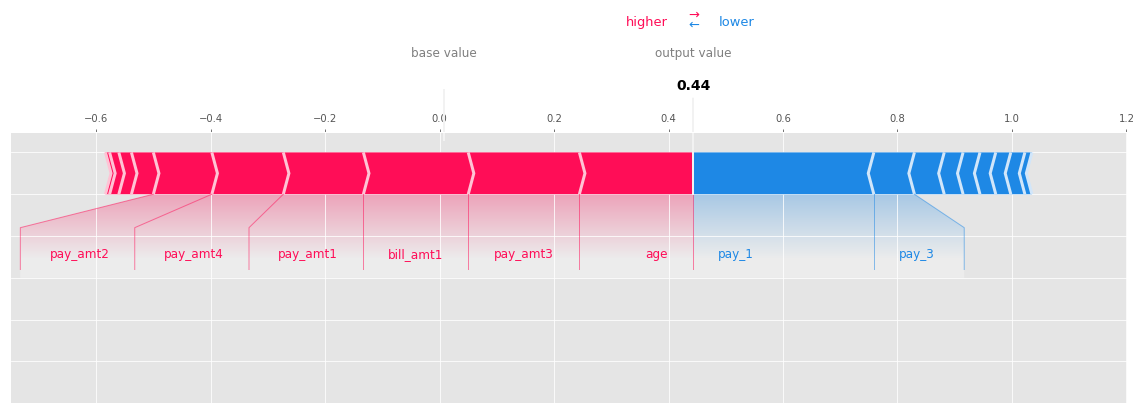

In [254]:
shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[2025,:], feature_names=top_indices, figsize=(20,5), matplotlib= True )

In [255]:
y_test_pred[906]

0.83700293

In [256]:
X_test_frame = pd.DataFrame(X_test)

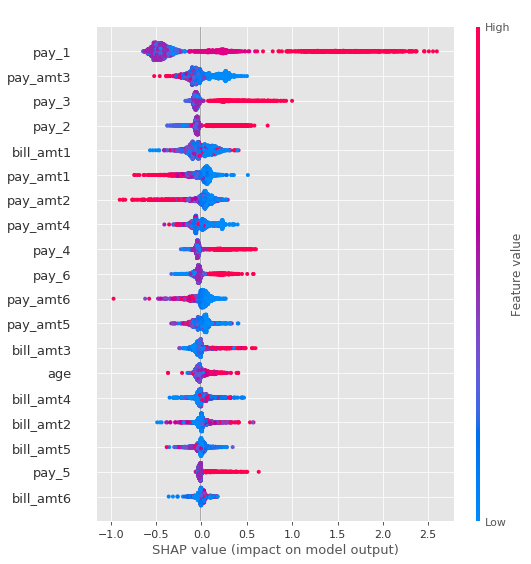

In [258]:
# for entire model 
shap.summary_plot(shap_values, X_test, feature_names=top_indices)

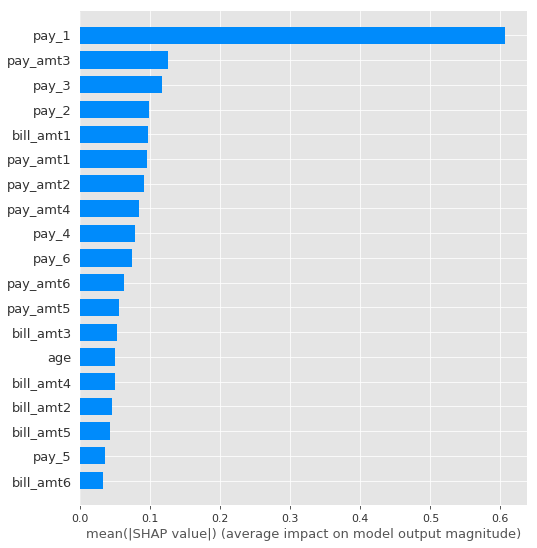

In [259]:
#for entire model
shap.summary_plot(shap_values, X_test, feature_names=top_indices, plot_type="bar")
#feature_names=list(X.columns[top_indices])

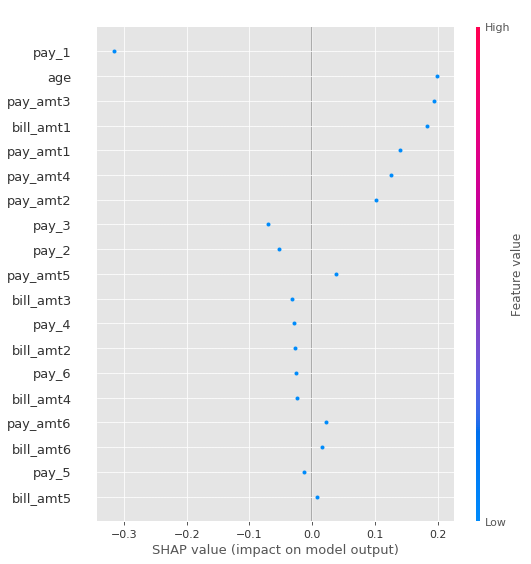

In [260]:
# for individual data point
shap.summary_plot(shap_values[[2025]], X_test[[2025]], feature_names=top_indices)

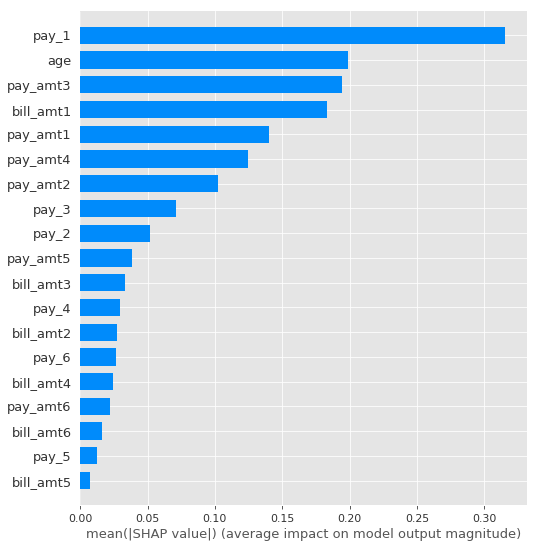

In [261]:
# for individual data point

shap.summary_plot(shap_values[[2025]], X_test[[2025]], feature_names=top_indices, plot_type="bar")
